# **Libraries**

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
transform = transforms.ToTensor()

In [84]:
train_data = datasets.MNIST(root='/content/sample_data/cnn_data', train=True, download=True, transform=transform)

In [85]:
test_data = datasets.MNIST(root='/content/sample_data/cnn_data', train=False, download=True, transform=transform)

In [86]:
labels = torch.tensor([label for _, label in train_data])
num_samples = len(train_data)
image_shape = train_data[0][0].shape
unique_classes = torch.unique(labels)
class_counts = torch.stack([(labels == c).sum() for c in unique_classes])
print(f"Total number of images: {num_samples}")
print(f"Image size: {image_shape[1]} x {image_shape[2]} pixels")
print(f"Number of digit classes: {len(unique_classes)}")
print(f"Counts per class: {class_counts.tolist()}")

Total number of images: 60000
Image size: 28 x 28 pixels
Number of digit classes: 10
Counts per class: [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


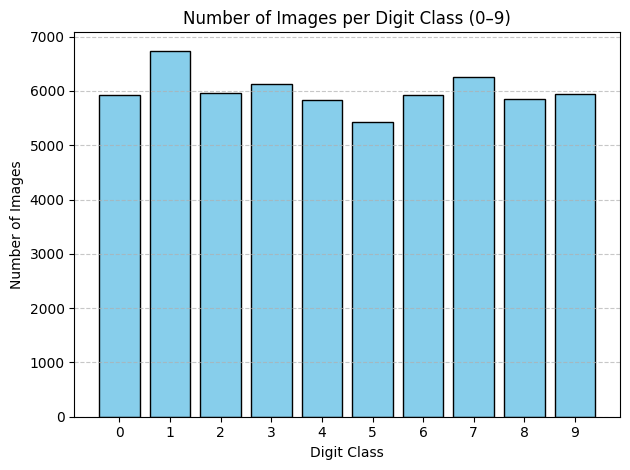

In [87]:
plt.bar(unique_classes.tolist(), class_counts.tolist(), color='skyblue', edgecolor='black')
plt.xticks(unique_classes.tolist())
plt.xlabel('Digit Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Digit Class (0–9)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

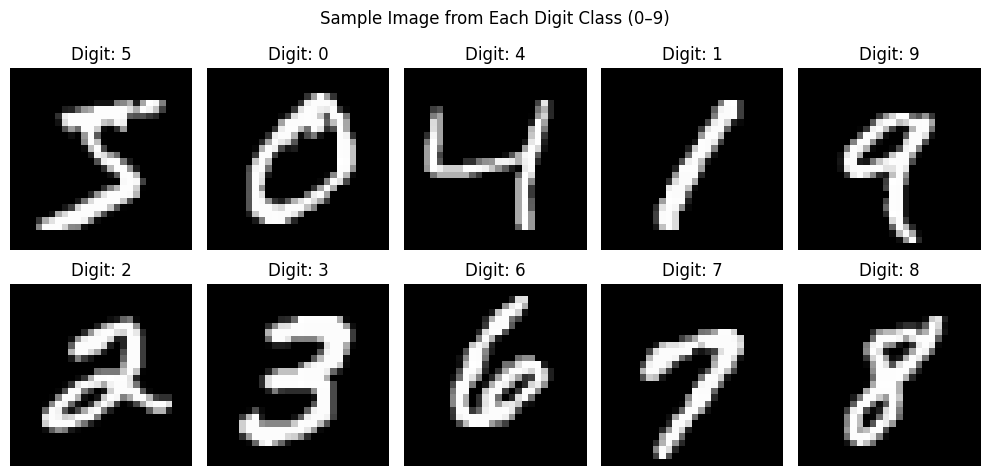

In [88]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
shown = set()

for ax in axes.ravel():
    for img, label in train_data:
        if label not in shown:

            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(f"Digit: {label}")
            ax.axis('off')
            shown.add(label)
            break

plt.suptitle("Sample Image from Each Digit Class (0–9)")
plt.tight_layout()
plt.show()

In [89]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

# Our ConvolutionalNetwork Model

In [90]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)

    X = X.view(-1, 16*5*5)

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [91]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# **Training**

In [93]:
epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    running_loss = 0.0
    batch_count = 0
    for X_train, y_train in train_loader:
        y_pred = model(X_train)                   # Forward pass
        loss = criterion(y_pred, y_train)         # Loss calculation

        optimizer.zero_grad()                     # Old gradients clear
        loss.backward()                           # Backpropagation
        optimizer.step()                          # Update weights

        running_loss += loss.item()
        batch_count += 1

    avg_loss = running_loss / batch_count         # Har epoch ka average
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss = {avg_loss:.4f}")

Epoch 1/5, Average Loss = 0.3347
Epoch 2/5, Average Loss = 0.0952
Epoch 3/5, Average Loss = 0.0678
Epoch 4/5, Average Loss = 0.0529
Epoch 5/5, Average Loss = 0.0440


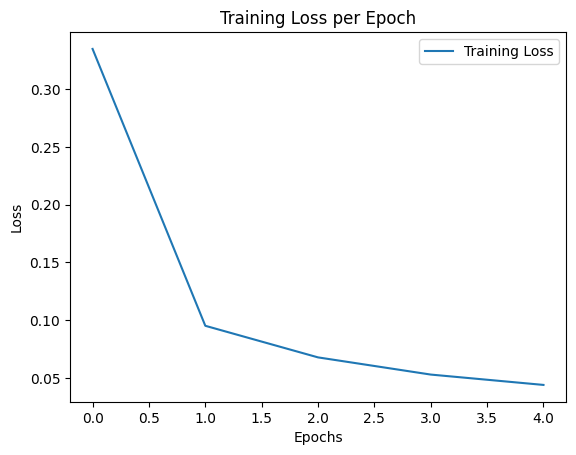

In [105]:
plt.plot(train_losses, label="Training Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Testing**

In [94]:
test_load_everything = DataLoader(test_data, batch_size=1000, shuffle=False)

In [95]:
correct = 0
total = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
            y_val = model(X_test)
            predicted = torch.max(y_val, 1)[1]
            correct += (predicted == y_test).sum().item()
            total += y_test.size(0)

    acc = 100 * correct / total
    test_accuracies.append(acc)
    print(f"Test Accuracy after Epoch {epoch+1}: {acc:.2f}%")

Test Accuracy after Epoch 5: 98.89%


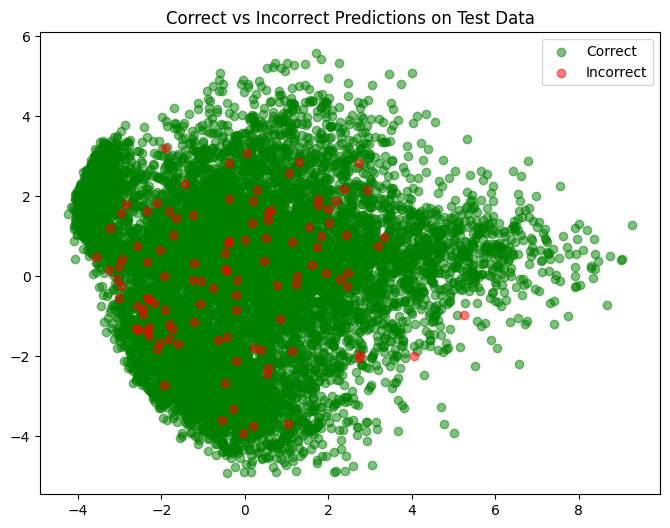

In [96]:
from sklearn.decomposition import PCA

test_loader_full = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader_full:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        break

correct_mask = (predicted == y_test)

X_flat = X_test.view(len(X_test), -1)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_flat)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[correct_mask, 0], X_2d[correct_mask, 1],
            c="green", alpha=0.5, label="Correct")
plt.scatter(X_2d[~correct_mask, 0], X_2d[~correct_mask, 1],
            c="red", alpha=0.5, label="Incorrect")
plt.legend()
plt.title("Correct vs Incorrect Predictions on Test Data")
plt.show()


In [97]:
test_data[2781]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [98]:
test_data[2781][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [99]:
test_data[2781][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

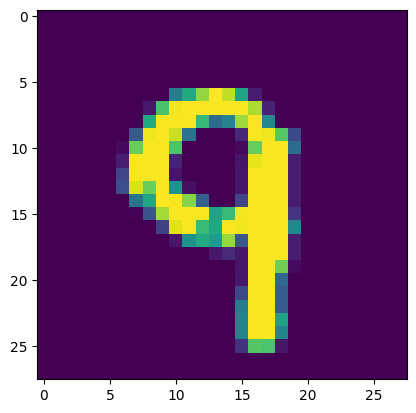

In [100]:
plt.imshow(test_data[2781][0].reshape(28,28))

In [101]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[2781][0].view(1,1,28,28))

In [102]:
new_prediction

tensor([[-1.7118e+01, -2.2047e+01, -1.5945e+01, -1.2469e+01, -1.0056e+01,
         -1.3174e+01, -2.4814e+01, -1.3139e+01, -9.0331e+00, -1.7022e-04]])

In [103]:
new_prediction.argmax()

tensor(9)